# CS273P Final Project

### Group 13: Connor McManigal, Peyton Politewicz, Harold Hin Ng

### Import Libraries and Read in the Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from collections import Counter
import re
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob, Word, Blobber

from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv("Recipe Reviews and User Feedback Dataset.csv")
df = pd.DataFrame(df)

## Data Cleaning

In [4]:
# Check dataframe shape
df.shape

(18182, 15)

In [5]:
# Drop unneccessary column and check dataframe
df.drop(columns=['Unnamed: 0'], inplace = True)
df = df.dropna()
df.shape

(18180, 14)

In [6]:
# Change unix time to date time
df['created_at'] = pd.to_datetime(df['created_at'], unit = 's')

# Check time('created_at') changes and look at unique values
df['created_at'].unique() # returns 2695 unique timestamps

<DatetimeArray>
['2022-10-13 00:11:29', '2022-10-09 01:08:07', '2022-09-28 22:35:57',
 '2022-08-29 15:43:28', '2022-10-04 20:03:43', '2022-08-24 15:19:11',
 '2022-02-05 19:20:05', '2022-02-04 02:35:14', '2022-02-04 00:05:24',
 '2022-01-26 22:57:19',
 ...
 '2022-05-09 18:14:14', '2022-04-08 07:21:21', '2022-03-21 12:27:35',
 '2022-02-11 05:02:10', '2022-02-01 04:29:27', '2022-02-23 22:41:52',
 '2021-08-08 21:44:22', '2021-06-02 15:48:18', '2021-02-11 14:06:47',
 '2021-02-11 09:45:20']
Length: 2695, dtype: datetime64[ns]

In [7]:
# Perform and add sentiment analysis columns using vader and textblob
pol_list1 = []
pol_list2 = []
sub_list = []
sid_obj = SentimentIntensityAnalyzer()

for row in df.iloc[:, 13]: # loop through text column to calculate vader polarity, textblob polarity and subjectivity, as well as difference in polarity scores
    temp = TextBlob(row)
    sent_dict = sid_obj.polarity_scores(row)
    pol_list1.append(sent_dict['compound'])
    pol_list2.append(temp.sentiment.polarity)
    sub_list.append(temp.sentiment.subjectivity)


df = df.assign(polarity_from_vader = pol_list1) # add columns to existing df
df = df.assign(polarity_from_blob = pol_list2)

pol_list1 = np.array(pol_list1)
pol_list2 = np.array(pol_list2)
temp_diff_btw_vader_and_blob = np.subtract(pol_list1, pol_list2)
diff_btw_vader_and_blob = temp_diff_btw_vader_and_blob.tolist()
df = df.assign(diff_in_polarity_scores = diff_btw_vader_and_blob)
df = df.assign(subjectivity = sub_list)

In [8]:
# Create votescore attribute to reflect overall rating of comment
df['votescore'] = df['thumbs_up'] - df['thumbs_down']
df = df.reset_index(drop = True)

In [9]:
# Create dense rank(index) for each post on respective recipe based on time posted
df.sort_values(by=['recipe_number', 'created_at'], inplace = True)
df['thread_index'] = df.groupby('recipe_number')['created_at'].rank(method='dense').astype(int)

In [10]:
df['review_length'] = df['text'].apply(lambda x: len(x))
df.head()

recipe_number  recipe_code         recipe_name  \
544              1        14299  Creamy White Chili   
616              1        14299  Creamy White Chili   
644              1        14299  Creamy White Chili   
643              1        14299  Creamy White Chili   
641              1        14299  Creamy White Chili   

                     comment_id                        user_id      user_name  \
544  sp_aUSaElGf_14299_c_108956  u_1oKVZzv4THPuCQ2sIogt3sy5uFY  knofflerrocks   
616  sp_aUSaElGf_14299_c_117943  u_1oKVggQUdGID7oRqTsDfStoLlTg  rockstaralice   
644  sp_aUSaElGf_14299_c_148637  u_1oKVsHlQ6OuUN7SveHTTNlqdXwL      MzExpeess   
643  sp_aUSaElGf_14299_c_387209  u_1oKVsHlQ6OuUN7SveHTTNlqdXwL      MzExpeess   
641  sp_aUSaElGf_14299_c_406862  u_1oKVrE8WzwHBbzCK1A1gHyKu5FR    josiezanker   

     user_reputation          created_at  reply_count  thumbs_up  ...  stars  \
544                1 2021-02-11 09:22:16            0          0  ...      5   
616                1 2021-02-11 09:23:42            0          0  ...      5   
644                1 2021-02-11 09:36:16            0          0  ...      5   
643                1 2021-02-11 10:14:52            0          0  ...      5   
641                1 2021-02-11 10:31:25            0          0  ...      5   

     best_score                                               text  \
544         100  <p>A favorite of my hubby. He loves the flavor...   
616         100               <p>Awesome!!!!!!!!!!!!!!!!!!!!!!</p>   
644         100  <p>Great flavor, fast and easy to prepare. Wil...   
643         100  Great flavor, fast and easy to prepare. Will a...   
641         100  My husband and I love this recipe!  We make it...   

    polarity_from_vader  polarity_from_blob  diff_in_polarity_scores  \
544              0.7901            0.500000                 0.290100   
616              0.0000            0.000000                 0.000000   
644              0.4404            0.211111                 0.229289   
643              0.7906            0.358333                 0.432267   
641              0.6988            0.781250                -0.082450   

     subjectivity  votescore  thread_index  review_length  
544      1.000000          0             1             75  
616      0.000000          0             2             36  
644      0.477778          0             3            110  
643      0.545833          0             4            104  
641      0.600000          0             5             53  

[5 rows x 21 columns]

In [11]:
df.shape # check size of final wrangled dataset

(18180, 21)

## Exploratory Data Analysis

In [12]:
# Check time range of recipe reviews
min = df['created_at'].min()
max = df['created_at'].max()
print(f'Recipe reviews are from "{min}" to "{max}"')

Recipe reviews are from "2021-02-11 09:22:16" to "2022-10-14 14:00:35"


In [13]:
# Find reviews with references
reference_text = df[df['text'].str.contains('&#')]
print(f"{reference_text.shape[0]} reviews reference other previous reviews denoted with '&#'")

6336 reviews reference other previous reviews denoted with '&#'


In [14]:
# Take look at some of the reviews ('text')
df['text'].head()

544    <p>A favorite of my hubby. He loves the flavor...
616                 <p>Awesome!!!!!!!!!!!!!!!!!!!!!!</p>
644    <p>Great flavor, fast and easy to prepare. Wil...
643    Great flavor, fast and easy to prepare. Will a...
641    My husband and I love this recipe!  We make it...
Name: text, dtype: object

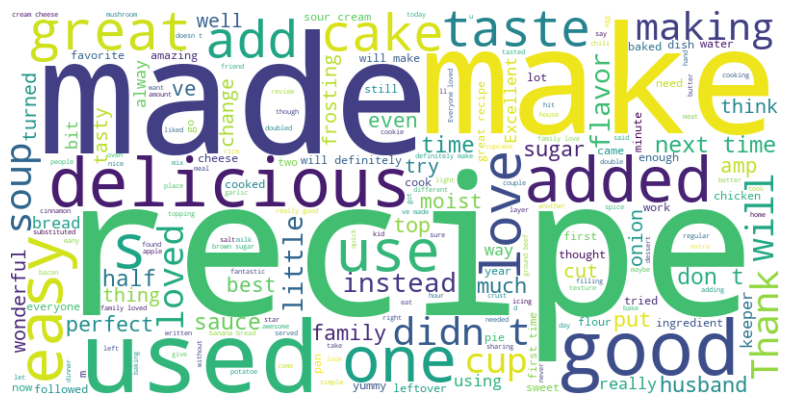

In [15]:
# Create a wordcloud from all the text
text_data = " ".join(df['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
# Find min and max length of characters in text
min_length = np.inf
max_length = -np.inf

for text in df['text']:
    text_length = len(text)
    if text_length < min_length:
        min_length = text_length
    if text_length > max_length:
        max_length = text_length

print("Minimum length of characters:", min_length)
print("Maximum length of characters:", max_length)

Minimum length of characters: 1
Maximum length of characters: 2742


In [17]:
# Which texts have length 1?
texts_length_1 = []

for index, text in enumerate(df['text']):
    if len(text) == 1:
        texts_length_1.append((index, text))

if texts_length_1:
    print("Observations with text length of 1:")
    for index, text in texts_length_1:
        print(f"Index: {index}, Text: {text}")
else:
    print("No observations with text length of 1.")

Observations with text length of 1:
Index: 22, Text: .
Index: 23, Text: .
Index: 4186, Text: .
Index: 5977, Text: .
Index: 7391, Text: !
Index: 9908, Text:  
Index: 14929, Text:  
Index: 15983, Text: .


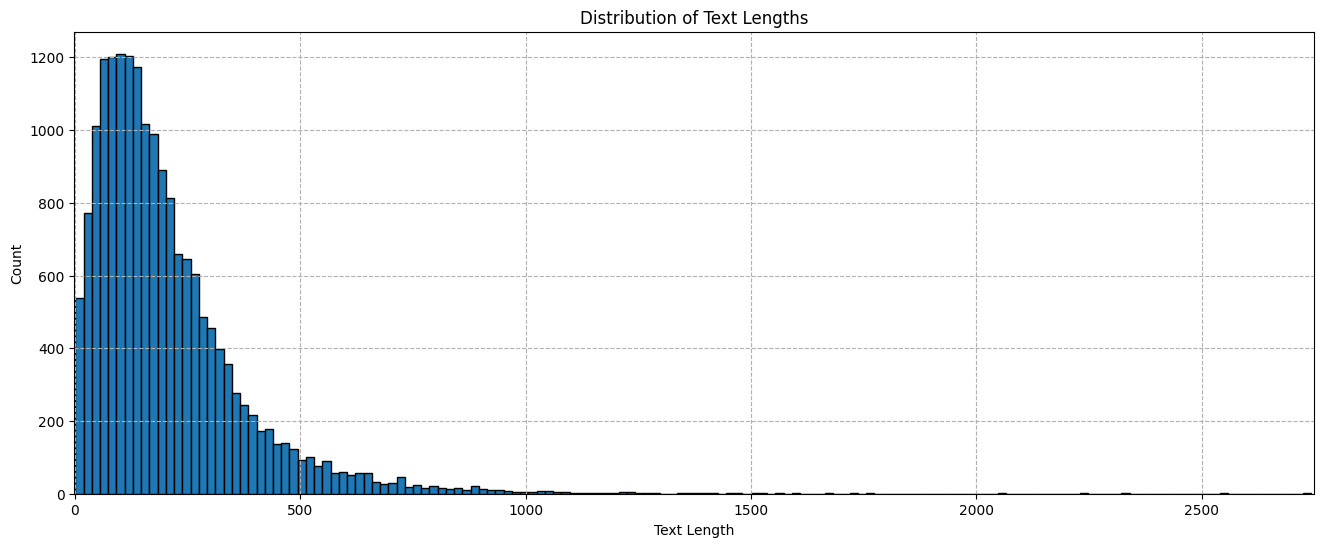

In [18]:
# Plot distribution of text lengths
text_lengths = df['text'].apply(len)

plt.figure(figsize=(16, 6))
plt.hist(text_lengths, bins=150, edgecolor = 'black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xlim(-1,2750)
plt.grid(True, linestyle='--', zorder=1)
plt.show()

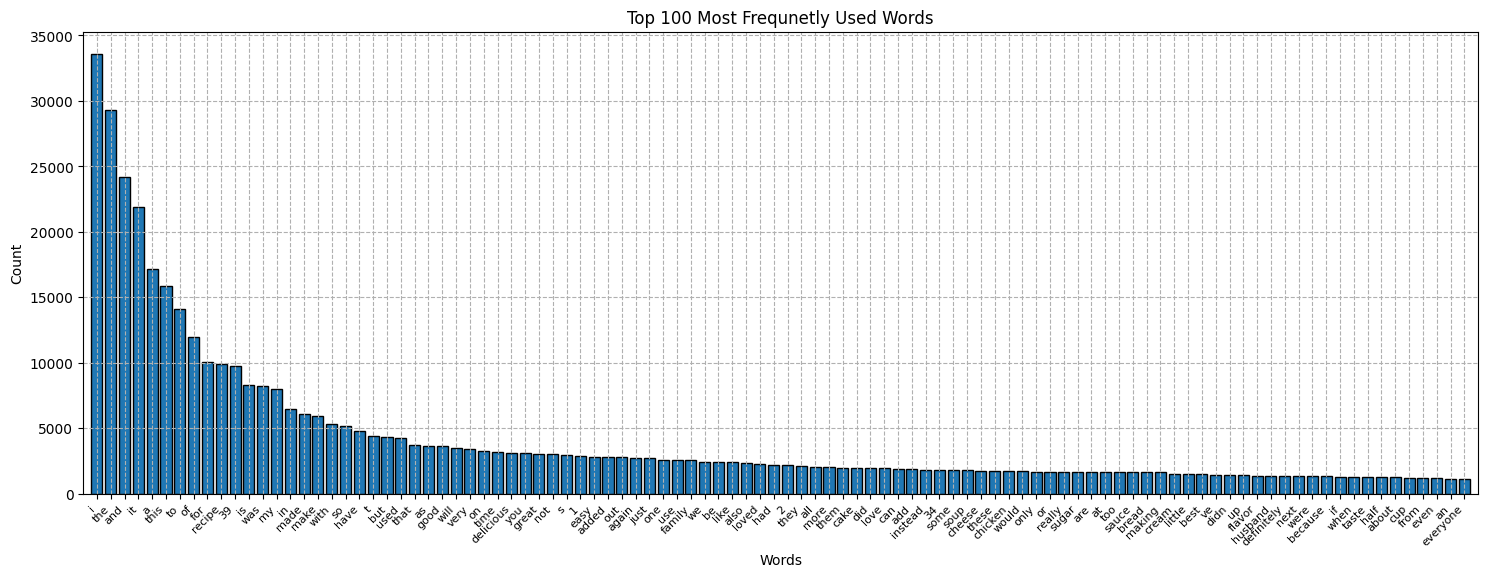

In [19]:
# Plot 100 most frequent words
all_text = ' '.join(df['text'])
words = re.findall(r'\b\w+\b', all_text.lower())

word_counts = Counter(words)
top_100_words = dict(word_counts.most_common(100))
x = np.arange(len(top_100_words))

plt.figure(figsize=(18, 6))
plt.bar(x, top_100_words.values(), edgecolor = 'black')
plt.title('Top 100 Most Frequnetly Used Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(x, top_100_words.keys(), rotation=45, ha='right', fontsize=8)
plt.xlim(-1, 100)
plt.grid(True, linestyle='--', zorder=1)
plt.show()

In [20]:
# Explore descriptive statistics of user reputations
df['user_reputation'].describe()

count    18180.000000
mean         2.159736
std         10.015210
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        520.000000
Name: user_reputation, dtype: float64

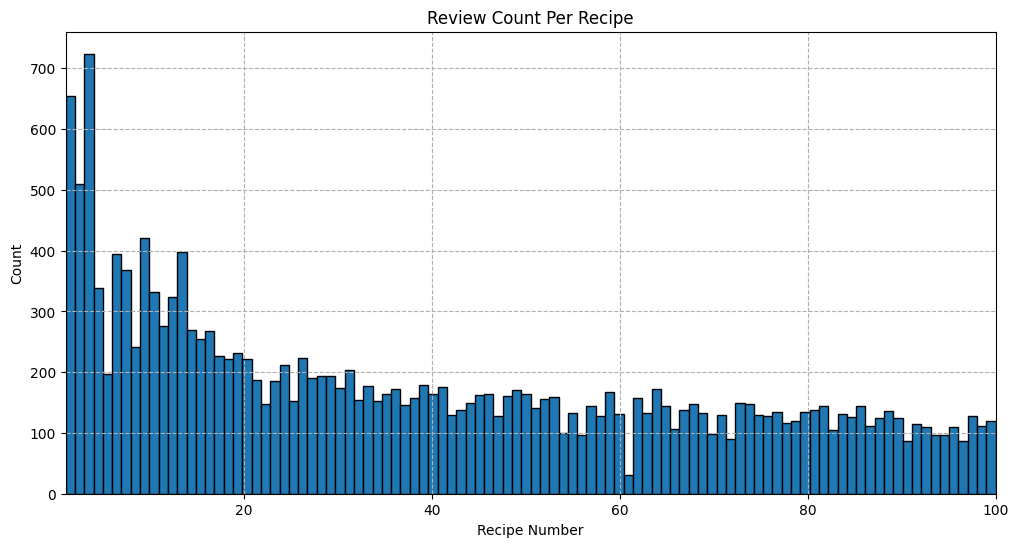

In [21]:
# Plot counts of number of reviews per recipe
plt.figure(figsize = (12,6))
plt.hist(df['recipe_number'], bins = 100, edgecolor = 'black')
plt.title('Review Count Per Recipe')
plt.xlabel('Recipe Number')
plt.ylabel('Count')
plt.xlim(1,100)
plt.grid(True, linestyle='--', zorder=0)
plt.show()

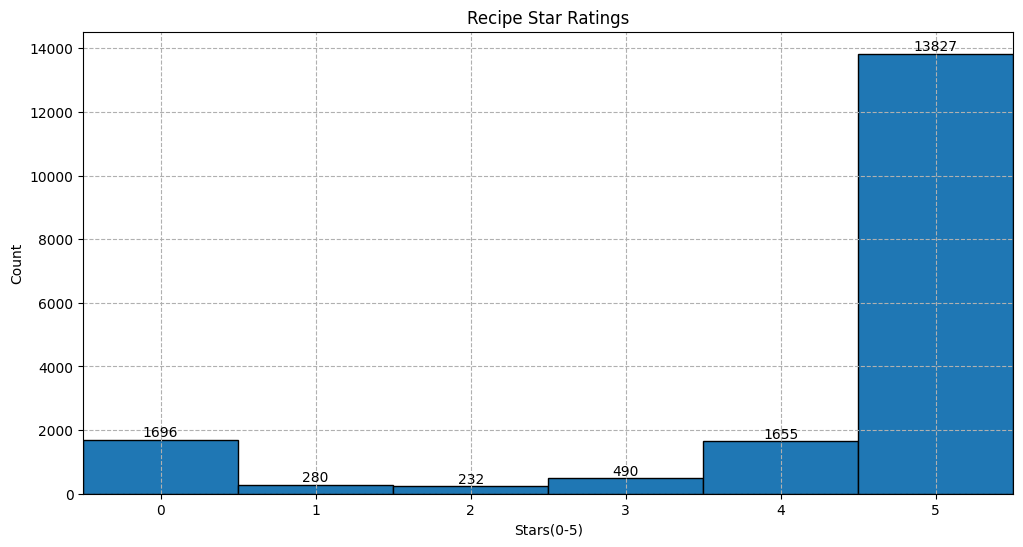

In [22]:
# Check distribution of recipe star ratings
bin_edges = np.arange(-0.5, 6.5, 1)

plt.figure(figsize=(12,6))
counts, bins, _ = plt.hist(df['stars'], bins = bin_edges, edgecolor = 'black', zorder=0)

# Add annotations at the top of each bin
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + 0.5, count, str(int(count)), ha='center', va='bottom')

plt.title('Recipe Star Ratings')
plt.xlabel('Stars(0-5)')
plt.ylabel('Count')
plt.xlim(-0.5,5.5)
plt.grid(True, linestyle='--', zorder=1)
plt.show()

In [23]:
# Get descriptive statistics on votescore
df['votescore'].describe()

count    18180.000000
mean         0.539989
std          4.337018
min       -121.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        103.000000
Name: votescore, dtype: float64

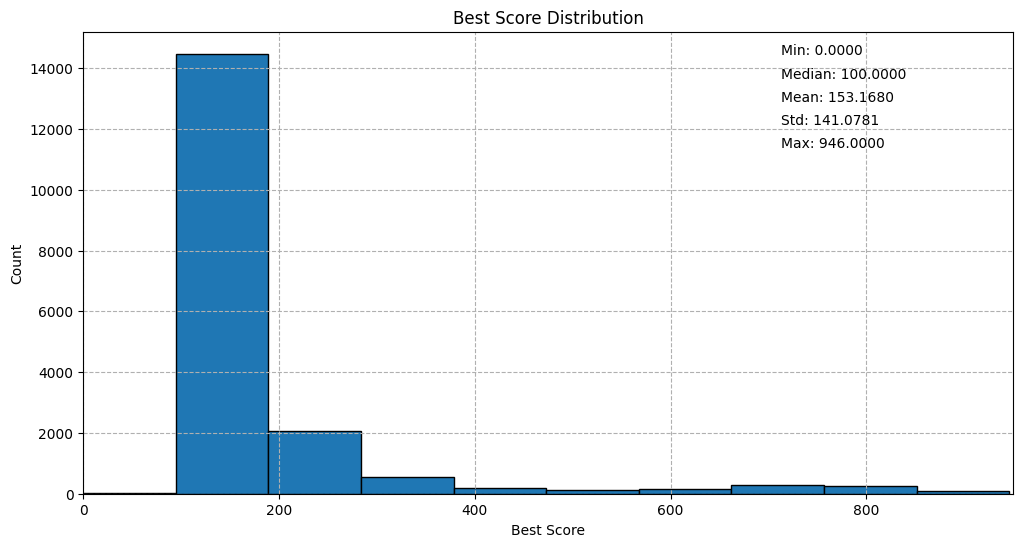

In [24]:
# Plot best_score distribution
plt.figure(figsize = (12,6))
plt.hist(df['best_score'], bins = 10, edgecolor = 'black')
plt.title('Best Score Distribution')
plt.xlabel('Best Score')
plt.ylabel('Count')
plt.xlim(0,950)
plt.grid(True, linestyle='--', zorder=0)

stats = {
    'Min': np.min(df['best_score']),
    'Median': np.percentile(df['best_score'], 50),
    'Mean': np.mean(df['best_score']),
    'Std': np.std(df['best_score']),
    'Max': np.max(df['best_score'])
}

for i, (key, value) in enumerate(stats.items()):
    plt.text(0.75, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=plt.gca().transAxes)

plt.show()

#### Explore Sentiment Results

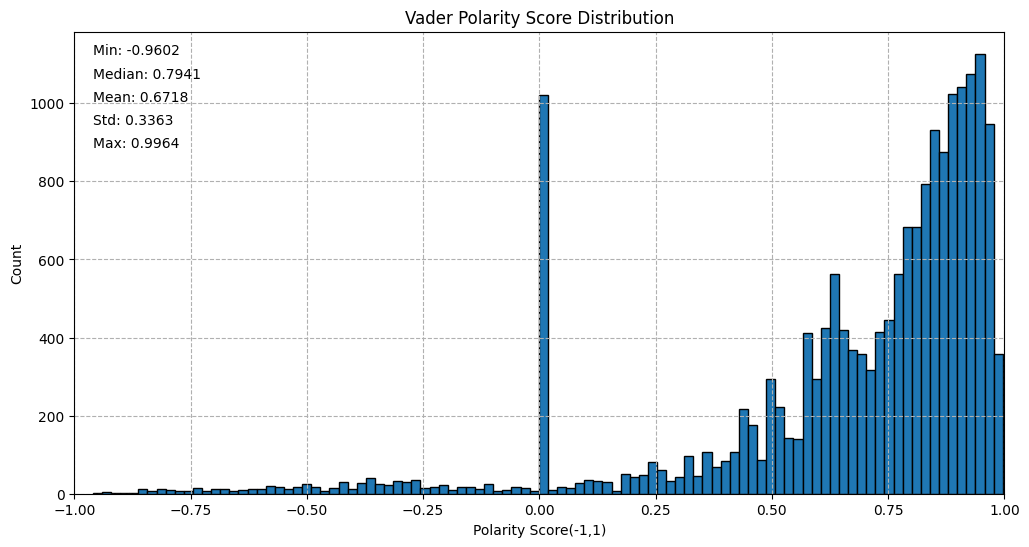

In [25]:
# Plot vader polarity distribution
plt.figure(figsize = (12,6))
plt.hist(df['polarity_from_vader'], bins = 100, edgecolor = 'black')
plt.title('Vader Polarity Score Distribution')
plt.xlabel('Polarity Score(-1,1)')
plt.ylabel('Count')
plt.xlim(-1,1)
plt.grid(True, linestyle='--', zorder=0)

stats = {
    'Min': np.min(df['polarity_from_vader']),
    'Median': np.percentile(df['polarity_from_vader'], 50),
    'Mean': np.mean(df['polarity_from_vader']),
    'Std': np.std(df['polarity_from_vader']),
    'Max': np.max(df['polarity_from_vader'])
}

for i, (key, value) in enumerate(stats.items()):
    plt.text(0.02, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=plt.gca().transAxes)

plt.show()

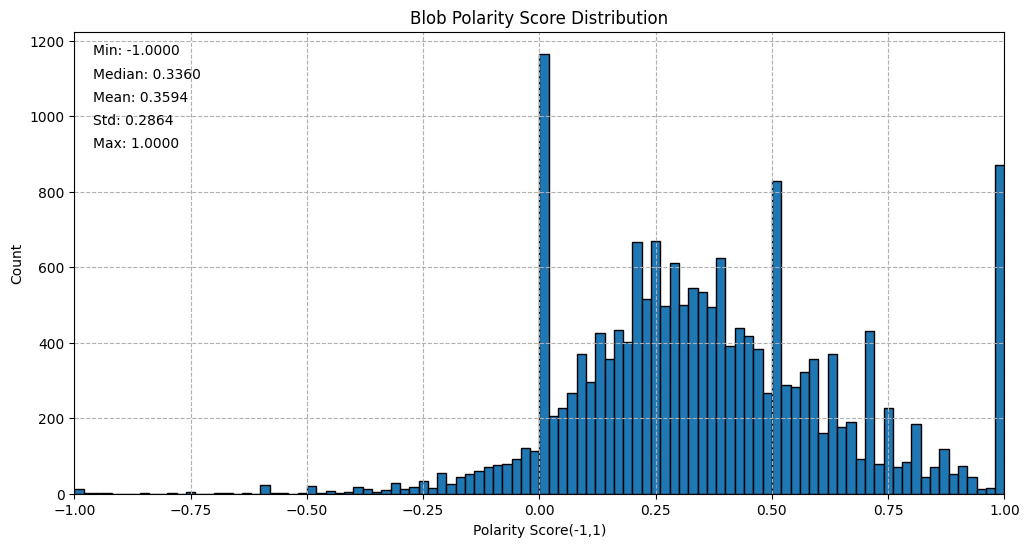

In [26]:
# Plot blob polarity distribution
plt.figure(figsize = (12,6))
plt.hist(df['polarity_from_blob'], bins = 100, edgecolor = 'black')
plt.title('Blob Polarity Score Distribution')
plt.xlabel('Polarity Score(-1,1)')
plt.ylabel('Count')
plt.xlim(-1,1)
plt.grid(True, linestyle='--', zorder=0)

stats = {
    'Min': np.min(df['polarity_from_blob']),
    'Median': np.percentile(df['polarity_from_blob'], 50),
    'Mean': np.mean(df['polarity_from_blob']),
    'Std': np.std(df['polarity_from_blob']),
    'Max': np.max(df['polarity_from_blob'])
}

for i, (key, value) in enumerate(stats.items()):
    plt.text(0.02, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=plt.gca().transAxes)

plt.show()

In [27]:
positive_polarity_vader = df[df['polarity_from_vader'] > 0.2]
positive_polarity_blob = df[df['polarity_from_blob'] > 0.2]

print('Vader Positive polarity observations: ', positive_polarity_vader.shape[0])
print('Blob Positive polarity observations: ', positive_polarity_blob.shape[0])

Vader Positive polarity observations:  16201
Blob Positive polarity observations:  12797


In [28]:
neutral_polarity_vader = df[(df['polarity_from_vader'] >= -0.2) & (df['polarity_from_vader'] <= 0.2)]
neutral_polarity_blob = df[(df['polarity_from_blob'] >= -0.2) & (df['polarity_from_blob'] <= 0.2)]


print('Vader Neutral polarity observations: ', neutral_polarity_vader.shape[0])
print('Blob Neutral polarity observations: ', neutral_polarity_blob.shape[0])

Vader Neutral polarity observations:  1388
Blob Neutral polarity observations:  5109


In [29]:
negative_polarity_vader = df[df['polarity_from_vader'] < -0.2]
negative_polarity_blob = df[df['polarity_from_blob'] < -0.2]

print('Vader Negative polarity observations: ', negative_polarity_vader.shape[0])
print('Blob Negative polarity observations: ', negative_polarity_blob.shape[0])

Vader Negative polarity observations:  591
Blob Negative polarity observations:  274


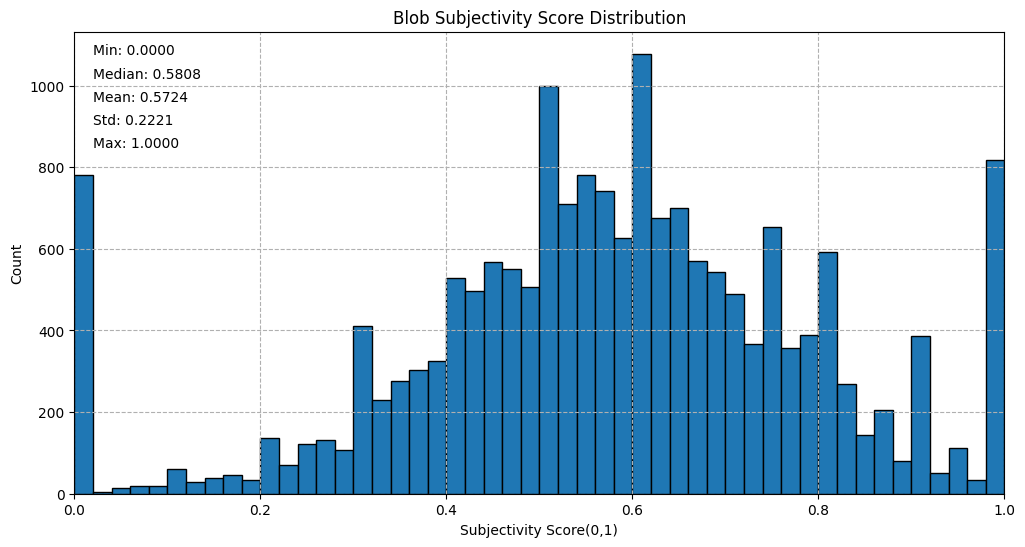

In [130]:
# Take a look at subjectivity from blob
plt.figure(figsize = (12,6))
plt.hist(df['subjectivity'], bins = 50, edgecolor = 'black')
plt.title('Blob Subjectivity Score Distribution')
plt.xlabel('Subjectivity Score(0,1)')
plt.ylabel('Count')
plt.xlim(0,1)
plt.grid(True, linestyle='--', zorder=0)

stats = {
    'Min': np.min(df['subjectivity']),
    'Median': np.percentile(df['subjectivity'], 50),
    'Mean': np.mean(df['subjectivity']),
    'Std': np.std(df['subjectivity']),
    'Max': np.max(df['subjectivity'])
}

for i, (key, value) in enumerate(stats.items()):
    plt.text(0.02, 0.95 - i * 0.05, f"{key}: {value:.4f}", transform=plt.gca().transAxes)

plt.show()


## Explore Correlation

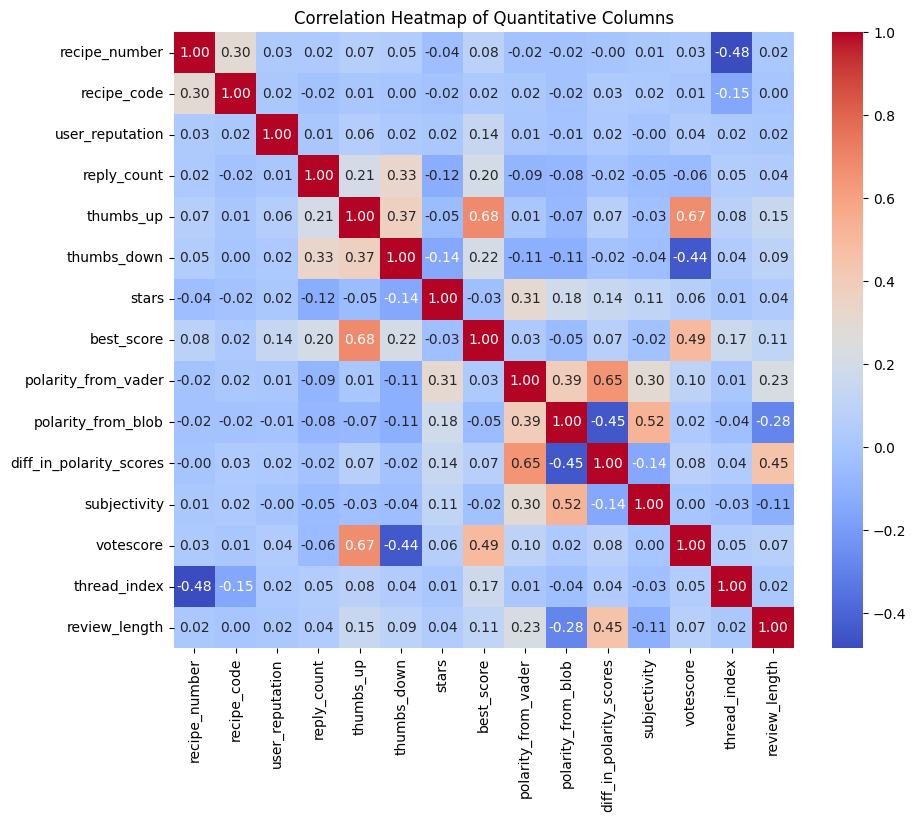

In [131]:
# Plot heatmap of quantitative columns
quant_df = df.select_dtypes(include=['int', 'float'])

plt.figure(figsize=(10, 8))
sns.heatmap(quant_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Quantitative Columns')
plt.show()

## Filtering, Further analysis, and Clustering

In [38]:
# Filter and create new DFs for specific best_scores and user_reputations
dfAlgoComments = df[df['best_score'] > 100].copy()
dfAlgoUsers = df[df['user_reputation'] != 1].copy()

dfAlgoComments['comment_length'] = dfAlgoComments['text'].str.len()
dfAlgoUsers['comment_length'] = dfAlgoUsers['text'].str.len()

In [39]:
print(dfAlgoComments.shape)
print(dfAlgoUsers.shape)

(4165, 21)
(1246, 21)


In [40]:
# Look at comment_length descriptive statistics
print('AlgoComments: Comment length', '\n', dfAlgoComments['comment_length'].describe(), '\n')
print('AlgoUsers: Comment length', '\n', dfAlgoUsers['comment_length'].describe())

AlgoComments: Comment length 
 count    4165.000000
mean      257.992797
std       208.991023
min         4.000000
25%       117.000000
50%       212.000000
75%       334.000000
max      2548.000000
Name: comment_length, dtype: float64 

AlgoUsers: Comment length 
 count    1246.000000
mean      233.450241
std       196.387173
min         2.000000
25%       110.000000
50%       190.000000
75%       298.000000
max      2322.000000
Name: comment_length, dtype: float64


In [41]:
# More descriptive statistics on AlgoComments
print('AlgoComments: Best score', '\n', dfAlgoComments['best_score'].describe(), '\n')
print('AlgoComments: User reputation', '\n', dfAlgoComments['user_reputation'].describe())

AlgoComments: Best score 
 count    4165.000000
mean      332.366387
std       212.613947
min       101.000000
25%       193.000000
50%       240.000000
75%       395.000000
max       946.000000
Name: best_score, dtype: float64 

AlgoComments: User reputation 
 count    4165.000000
mean        3.933974
std        19.908212
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       520.000000
Name: user_reputation, dtype: float64


In [42]:
# More descriptive statistics on AlgoUsers
print('AlgoUsers: Best score', '\n', dfAlgoUsers['best_score'].describe(), '\n')
print('AlgoUsers: User reputation', '\n', dfAlgoUsers['user_reputation'].describe())

AlgoUsers: Best score 
 count    1246.000000
mean      223.271268
std       199.913625
min         0.000000
25%       100.000000
50%       100.000000
75%       258.000000
max       934.000000
Name: best_score, dtype: float64 

AlgoUsers: User reputation 
 count    1246.000000
mean       17.921348
std        34.607568
min         0.000000
25%        10.000000
50%        10.000000
75%        20.000000
max       520.000000
Name: user_reputation, dtype: float64


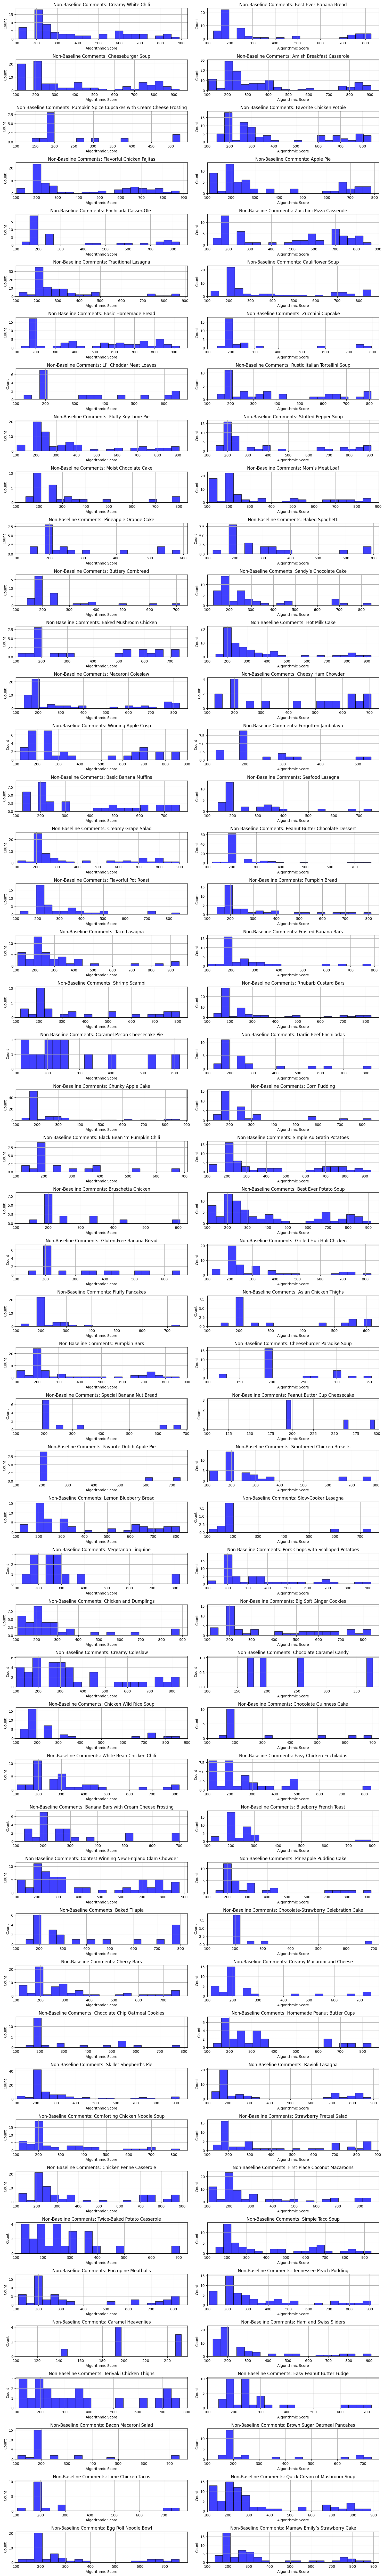

In [43]:
# Take look at filtered best_scores DF per recipe
recipeNames = df['recipe_name'].unique()

num_cols = 2  # number of columns
num_rows = 50  # number of rows

plt.figure(figsize=(15, 100))

# iterate over recipe names and plot histograms
for idx, names in enumerate(recipeNames, start=1):
    recipeFrame = dfAlgoComments[dfAlgoComments['recipe_name'] == names]
    plt.subplot(num_rows, num_cols, idx)
    recipeFrame['best_score'].hist(bins=20, alpha=0.75, color='blue', edgecolor='black')
    plt.title(f"Non-Baseline Comments: {names}")
    plt.xlabel("Algorithmic Score")
    plt.xlim(100, None)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

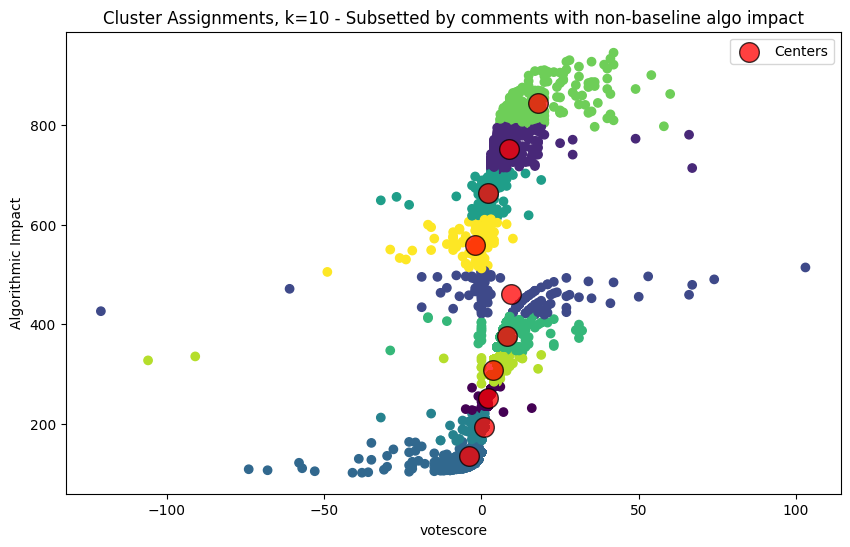

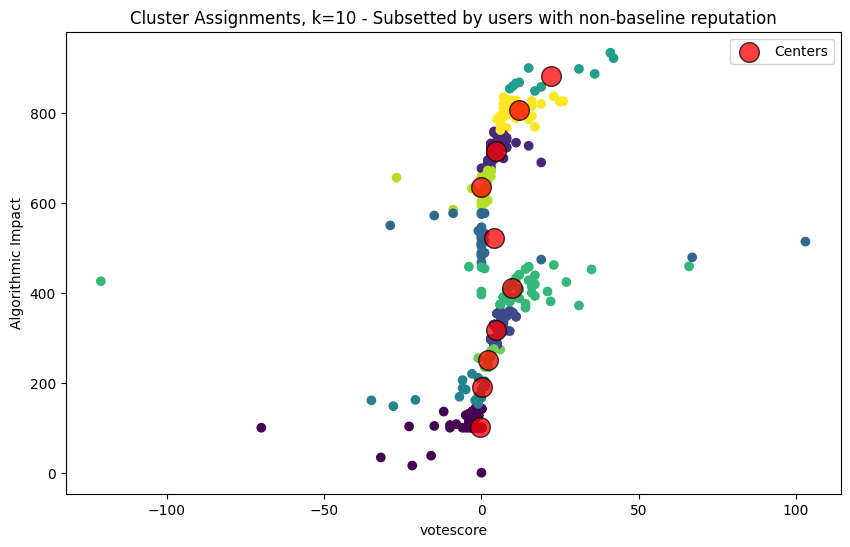

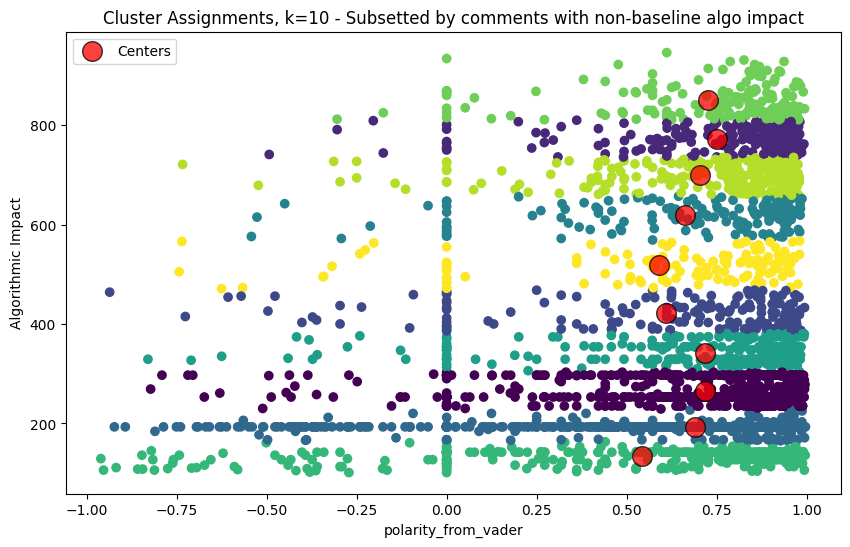

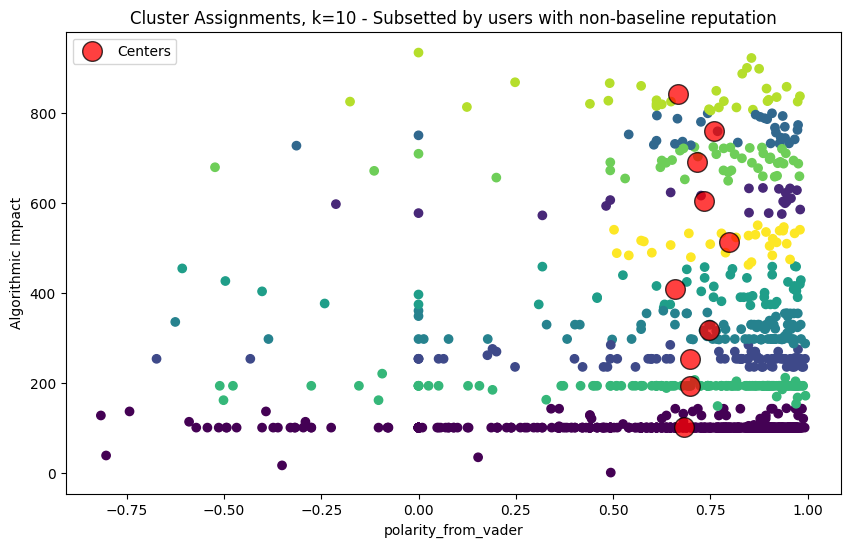

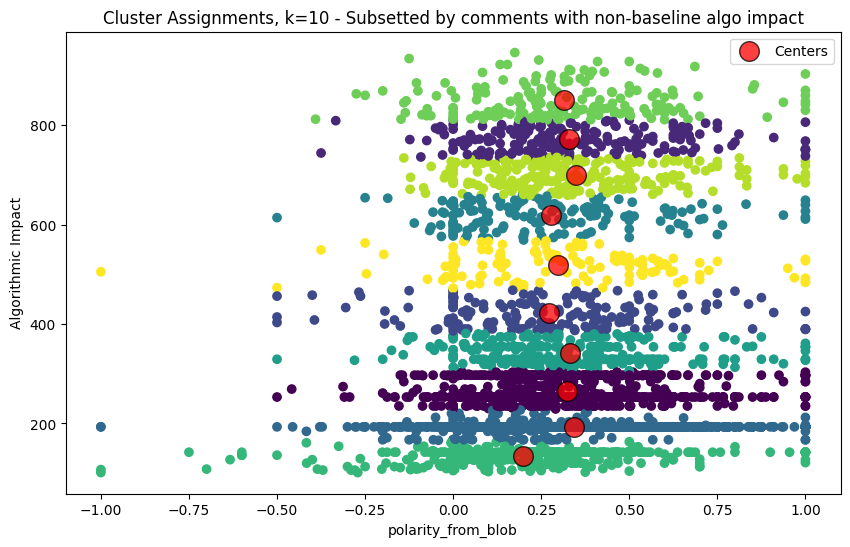

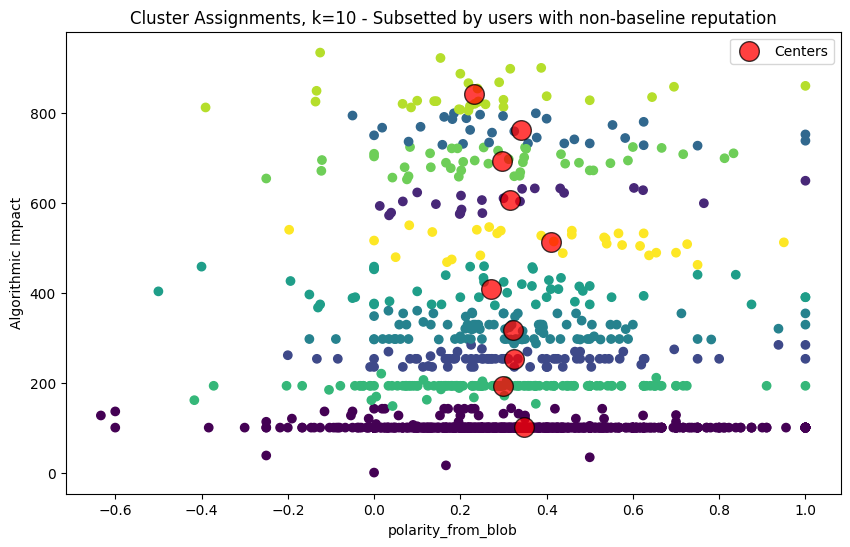

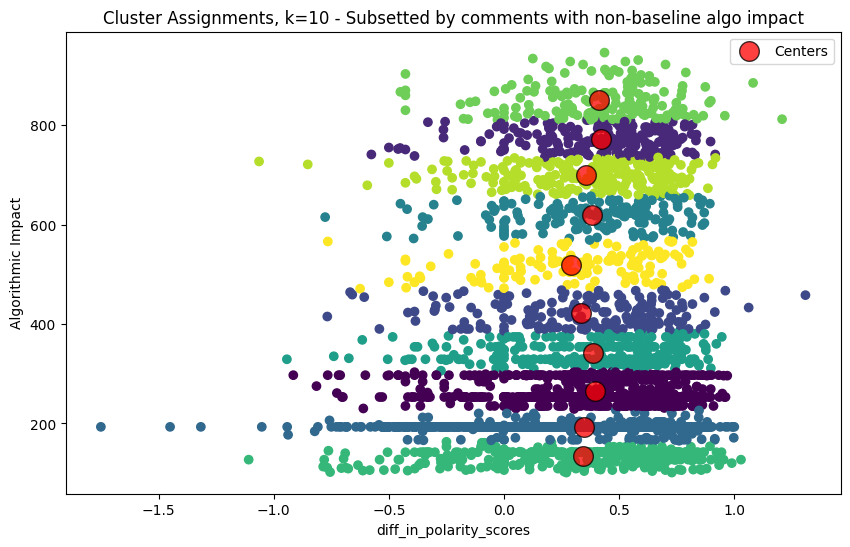

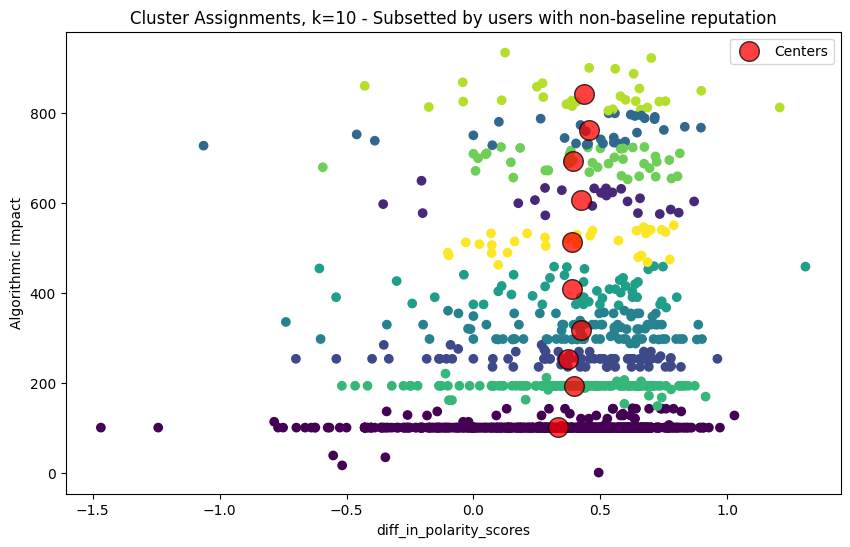

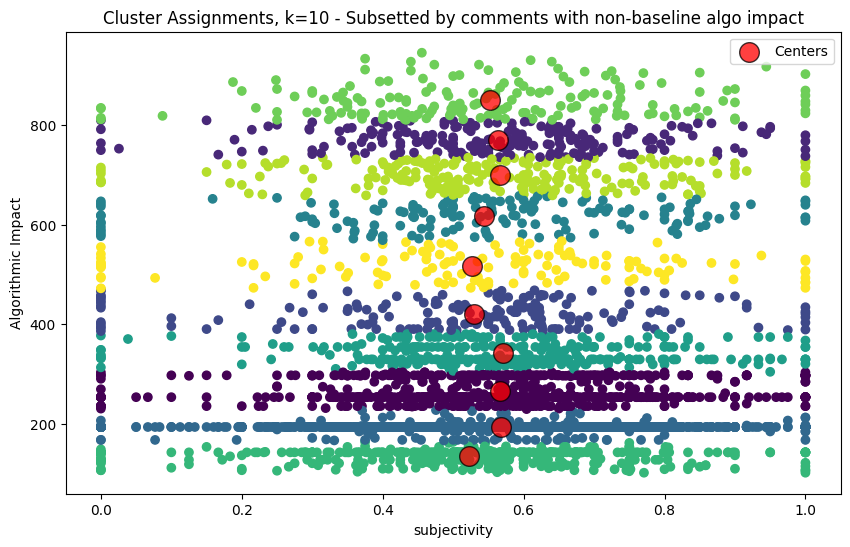

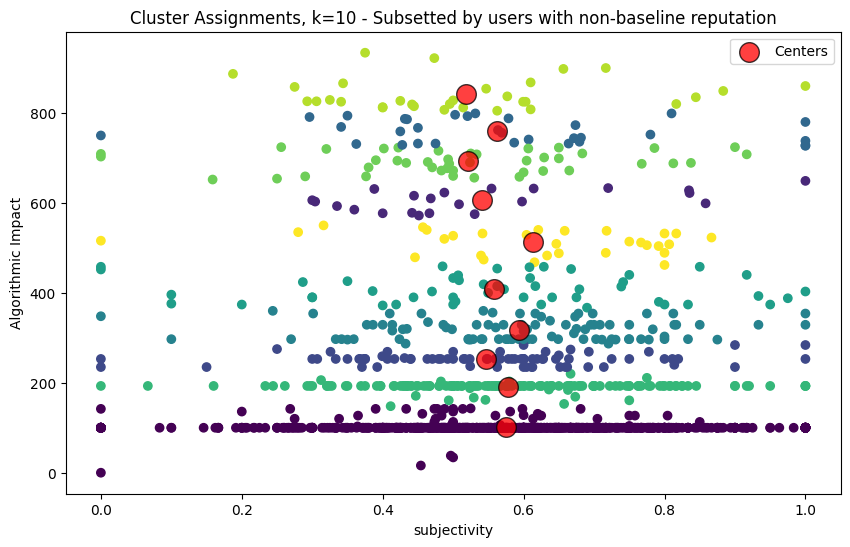

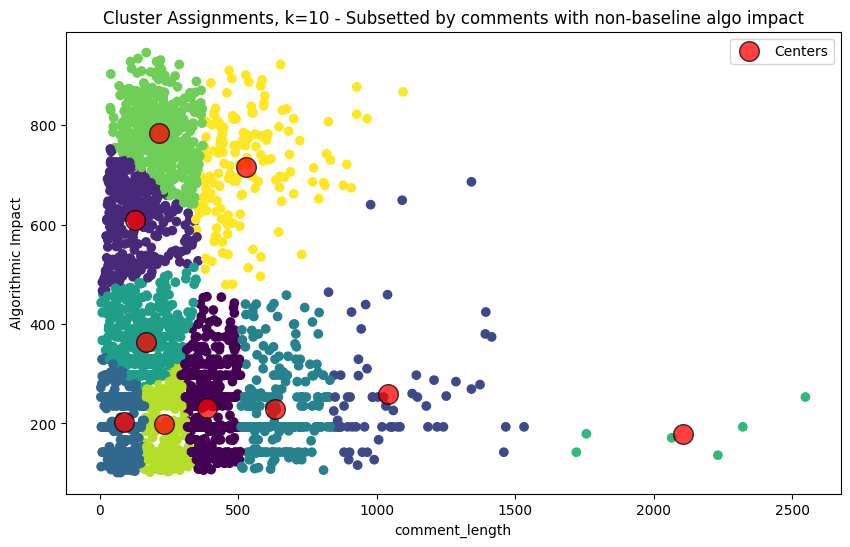

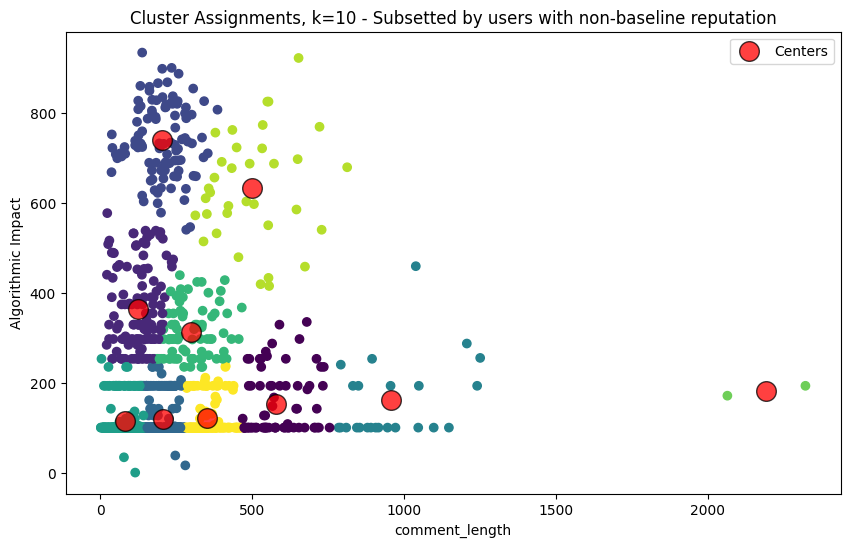

In [44]:
# Run K-Means (K=10) on AlgoComments and AlgoUsers
toTest = ['votescore', 'polarity_from_vader', 'polarity_from_blob', 'diff_in_polarity_scores', 'subjectivity', 'comment_length']
for param in toTest:

    kmeansDF = dfAlgoComments[[param, 'best_score']].copy()

    kmeans = KMeans(n_clusters = 10, random_state = 0, n_init = "auto").fit(kmeansDF)

    # Assigning the cluster centers
    kmeansDF['cluster'] = kmeans.labels_

    # Plotting the clusters
    plt.figure(figsize=(10, 6))

    # Scatter plot of the data with color-coding for clusters
    plt.scatter(kmeansDF[param], kmeansDF['best_score'], c=kmeansDF['cluster'], cmap='viridis')

    # Plot the cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='o', edgecolors='black', label='Centers')

    plt.title('Cluster Assignments, k=10 - Subsetted by comments with non-baseline algo impact')
    plt.xlabel(param)
    plt.ylabel('Algorithmic Impact')
    plt.legend(loc='best')
    plt.show()

    kmeansDF = dfAlgoUsers[[param, 'best_score']].copy()

    kmeans = KMeans(n_clusters = 10, random_state = 0, n_init = "auto").fit(kmeansDF)

    # Assigning the cluster centers
    kmeansDF['cluster'] = kmeans.labels_

    # Plotting the clusters
    plt.figure(figsize=(10, 6))

    # Scatter plot of the data with color-coding for clusters
    plt.scatter(kmeansDF[param], kmeansDF['best_score'], c=kmeansDF['cluster'], cmap='viridis')

    # Plot the cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='o', edgecolors='black', label='Centers')

    plt.title('Cluster Assignments, k=10 - Subsetted by users with non-baseline reputation')
    plt.xlabel(param)
    plt.ylabel('Algorithmic Impact')
    plt.legend(loc='best')
    plt.show()

## Stratification

In [31]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['recipe_number', 'recipe_code', 'recipe_name', 'comment_id', 'user_id', 'user_name', 'created_at', 'stars', 'text', 'diff_in_polarity_scores', 'best_score'])
y = df['best_score']

X_pos = X[(X['polarity_from_vader'] > 0.2) & (X['polarity_from_vader'] <= 1)]
y_pos = y[X_pos.index]

X_neut = X[(X['polarity_from_vader'] >= -0.2) & (X['polarity_from_vader'] <= 0.2)]
y_neut = y[X_neut.index]

X_neg = X[(X['polarity_from_vader'] >= -1) & (X['polarity_from_vader'] < -0.2)]
y_neg = y[X_neg.index]

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y_pos, test_size=0.2, random_state=42)
X_train_neut, X_test_neut, y_train_neut, y_test_neut = train_test_split(X_neut, y_neut, test_size=0.2, random_state=42)
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(X_neg, y_neg, test_size=0.2, random_state=42)

X_train = pd.concat([X_train_pos, X_train_neut, X_train_neg])
y_train = pd.concat([y_train_pos, y_train_neut, y_train_neg])
X_test = pd.concat([X_test_pos, X_test_neut, X_test_neg])
y_test = pd.concat([y_test_pos, y_test_neut, y_test_neg])

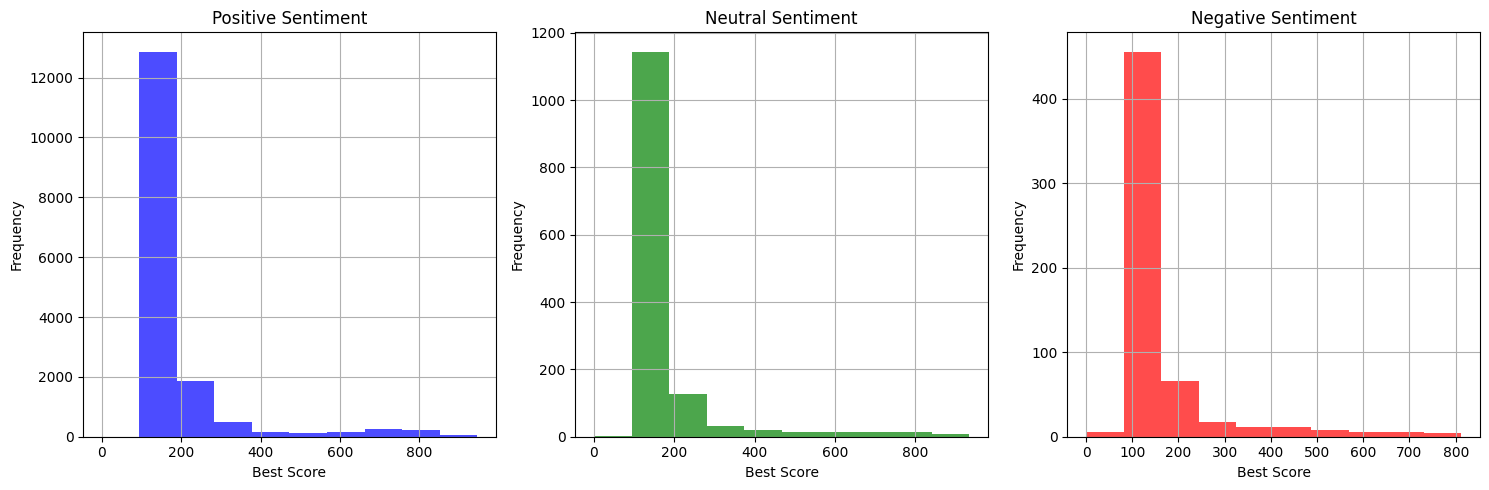

In [146]:
# Plot histograms for positive, neutral, and negative sentiment best scores
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(y_pos, color='blue', alpha=0.7)
axs[0].set_title('Positive Sentiment')
axs[0].set_xlabel('Best Score')
axs[0].set_ylabel('Frequency')
axs[0].grid()

axs[1].hist(y_neut, color='green', alpha=0.7)
axs[1].set_title('Neutral Sentiment')
axs[1].set_xlabel('Best Score')
axs[1].set_ylabel('Frequency')
axs[1].grid()

axs[2].hist(y_neg, color='red', alpha=0.7)
axs[2].set_title('Negative Sentiment')
axs[2].set_xlabel('Best Score')
axs[2].set_ylabel('Frequency')
axs[2].grid()

plt.tight_layout()
plt.show()

## Predicting best_score